In [1]:
import seaborn as sns
import folium
import folium.plugins as folium_plugins
from geopandas import GeoSeries, GeoDataFrame
import geopandas as gpd
import pandas as pd
import numpy as np
from os.path import exists


from utils.downloads import (
    Censo,
    Nivel,
    download_malha,
    download_dados,
)
from utils.geosampa_client import get_client
from utils.geo import calc_similarity

In [2]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

# Carregando os dados necessários

Para facilitar o desenvolvimento posterior, vamos concentrar os downloads e carregamentos iniciais nesta seção.

## Setores censitários de 2022

In [3]:
%%time
setores22 = download_malha(Censo.CENSO_2022, Nivel.SETORES)
setores22 = setores22[setores22['CD_MUN'] == '3550308']
setores22 = setores22.to_crs(epsg=31983)
setores22.sample(3)

INFO:root:Carregando a malha de setores do censo de 2022.
INFO:root:O arquivo data/cache/setores/2022/SP_Malha_Preliminar_2022.zip já foi baixado anteriormente. Usando cache local.


CPU times: user 1min 4s, sys: 1.01 s, total: 1min 5s
Wall time: 1min 12s


,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,CD_CONCURB,NM_CONCURB,v0001,v0002,v0003,v0004,v0005,v0006,v0007,geometry
89242,355030881000183P,0.032326,3,Sudeste,35,São Paulo,3550308,São Paulo,355030881,Tremembé,...,3550308,São Paulo/SP,889,352,352,0,2.886364,6.493506,308,"POLYGON ((339055.149 7406351.841, 339048.612 7..."
78572,355030843000571P,0.050477,3,Sudeste,35,São Paulo,3550308,São Paulo,355030843,Jardim Ângela,...,3550308,São Paulo/SP,387,124,124,0,3.252101,2.521008,119,"POLYGON ((321046.068 7379373.526, 321035.757 7..."
72292,355030826000211P,0.010468,3,Sudeste,35,São Paulo,3550308,São Paulo,355030826,Consolação,...,3550308,São Paulo/SP,146,106,106,0,1.871795,24.358974,78,"POLYGON ((331562.610 7394698.592, 331559.000 7..."


## Setores censitários de 2010

In [51]:
setores10 = download_malha(Censo.CENSO_2010, Nivel.SETORES)
setores10 = setores10[setores10['CD_GEOCODM'] == '3550308']
setores10 = setores10.to_crs(epsg=31983)
setores10.sample(3)

INFO:root:Carregando a malha de setores do censo de 2010.
INFO:root:O arquivo data/cache/setores/2010/sp_setores_censitarios.zip já foi baixado anteriormente. Usando cache local.


,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry
44870,110452.0,355030813000007,URBANO,35503081300,None,355030813,CACHOEIRINHA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,44871,"POLYGON ((330334.106 7403754.122, 330361.256 7..."
50049,115617.0,355030835000051,URBANO,35503083500,None,355030835,ITAIM BIBI,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,50050,"POLYGON ((327988.546 7387854.373, 327916.582 7..."
51380,116918.0,355030839000092,URBANO,35503083900,None,355030839,JAÇANÃ,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,51381,"POLYGON ((340479.268 7402481.778, 340549.505 7..."


Adicionalmente, precisamos carregar os dados de população e domicílios do censo de 2010, que não vêm junto com a geometria.

In [5]:
dados10_pop = download_dados(Censo.CENSO_2010, Nivel.SETORES, arquivo='Domicilio02_SP1.xls')
dados10_pop.head()

INFO:root:Carregando os dados de setores do censo de 2010.
INFO:root:O arquivo data/cache/setores/2010/SP_Capital_20231030.zip já foi baixado anteriormente. Usando cache local.


,Cod_setor,Situacao_setor,V001,V002,V003,V004,V005,V006,V007,V008,...,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132
0,355030801000001,1,806,800,623,66,28,399,27,360,...,1,0,0,425,425,0,0,415,10,0
1,355030801000002,1,913,913,891,22,0,567,36,261,...,0,0,0,495,495,0,0,421,74,0
2,355030801000003,1,625,625,595,4,18,462,5,151,...,0,0,0,329,318,11,0,309,9,0
3,355030801000004,1,572,572,496,11,65,229,8,286,...,0,0,0,296,296,0,0,274,12,10
4,355030801000005,1,754,754,716,3,30,340,15,354,...,0,0,0,399,399,0,0,162,210,27


In [6]:
dados10_dom = download_dados(Censo.CENSO_2010, Nivel.SETORES, arquivo='Domicilio01_SP1.XLS')
dados10_dom.head()

INFO:root:Carregando os dados de setores do censo de 2010.
INFO:root:O arquivo data/cache/setores/2010/SP_Capital_20231030.zip já foi baixado anteriormente. Usando cache local.


,Cod_setor,Situacao_setor,V001,V002,V003,V004,V005,V006,V007,V008,...,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241
0,355030801000001,1,268,266,203,20,11,136,7,116,...,0,0,1,1,0,0,0,0,0,0
1,355030801000002,1,306,306,298,8,0,194,10,85,...,0,0,0,0,0,0,0,0,0,0
2,355030801000003,1,189,189,177,1,7,135,1,50,...,0,0,0,0,0,0,0,0,0,0
3,355030801000004,1,181,181,154,4,23,76,2,87,...,0,0,0,0,0,0,0,0,0,0
4,355030801000005,1,240,240,226,1,12,105,4,112,...,0,0,0,0,0,0,0,0,0,0


In [7]:
dados10_renda = download_dados(Censo.CENSO_2010, Nivel.SETORES, arquivo='DomicilioRenda_SP1.XLS')
dados10_renda.head()

INFO:root:Carregando os dados de setores do censo de 2010.
INFO:root:O arquivo data/cache/setores/2010/SP_Capital_20231030.zip já foi baixado anteriormente. Usando cache local.


,Cod_setor,Situacao_setor,V001,V002,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012,V013,V014
0,355030801000001,1,2,907777,903817,3960,0,0,14,51,94,49,42,12,5,1
1,355030801000002,1,0,846525,846525,0,0,2,28,87,94,45,30,12,4,4
2,355030801000003,1,0,505662,505662,0,0,3,11,38,50,19,16,10,3,39
3,355030801000004,1,0,446011,446011,0,0,3,8,39,57,14,14,9,1,36
4,355030801000005,1,0,615215,615215,0,0,2,20,68,76,37,18,8,3,8


## Setores censitários de 2000

In [8]:
setores00 = download_malha(Censo.CENSO_2000, Nivel.SETORES)
setores00 = setores00[setores00['ID_'].str.startswith('3550308')]
setores00 = setores00.set_crs(epsg=31983, allow_override=True)
setores00 = setores00.to_crs(epsg=31983)
setores00.sample(3)

INFO:root:Carregando a malha de setores do censo de 2000.
INFO:root:O arquivo data/cache/setores/2000/3550308.zip já foi baixado anteriormente. Usando cache local.


,ID_,NAME1_,NAME2_,PARTS_,POINTS_,LENGTH_,AREA_,geometry
545,355030823000189,None,None,1,31,0.887830,0.027885,"POLYGON ((326035.000 7373452.000, 326016.000 7..."
7054,355030813000098,None,None,1,11,0.387883,0.009367,"POLYGON ((330684.000 7405177.000, 330771.000 7..."
4948,355030829000060,None,None,1,34,0.897233,0.026225,"POLYGON ((326536.000 7402385.000, 326515.000 7..."


Adicionalmente, precisamos carregar os dados de população e domicílios do censo de 2010, que não vêm junto com a geometria.

In [9]:
dados00_pop = download_dados(Censo.CENSO_2000, Nivel.SETORES, arquivo='Morador_SP1.XLS')
dados00_pop.head()

INFO:root:Carregando os dados de setores do censo de 2000.
INFO:root:O arquivo data/cache/setores/2000/Agregado_de_setores_2000_SP_RM.zip já foi baixado anteriormente. Usando cache local.


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,Cod_setor,Situacao,Tipo_do_setor,V0237,V0238,V0239,V0240,V0241,V0242,V0243,...,V0392,V0393,V0394,V0395,V0396,V0397,V0398,V0399,V0400,V0401
0,350390105000001,1,0,471,424,424,0,47,419.0,0.0,...,0.0,1.0,229.0,229.0,0.0,0.0,0.0,0.0,0.0,0.0
1,350390105000002,1,0,590,590,589,1,0,589.0,0.0,...,0.0,48.0,299.0,299.0,0.0,0.0,0.0,0.0,0.0,0.0
2,350390105000003,1,0,485,485,479,6,0,479.0,0.0,...,0.0,0.0,239.0,237.0,2.0,0.0,0.0,0.0,0.0,0.0
3,350390105000004,1,0,654,654,654,0,0,653.0,0.0,...,0.0,2.0,350.0,347.0,3.0,0.0,0.0,0.0,0.0,0.0
4,350390105000005,1,0,572,572,572,0,0,554.0,13.0,...,0.0,1.0,307.0,307.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
dados00_dom = download_dados(Censo.CENSO_2000, Nivel.SETORES, arquivo='Domicilio_SP1.XLS')
dados00_dom.head()

INFO:root:Carregando os dados de setores do censo de 2000.
INFO:root:O arquivo data/cache/setores/2000/Agregado_de_setores_2000_SP_RM.zip já foi baixado anteriormente. Usando cache local.


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,Cod_setor,Situacao,Tipo_do_setor,V0001,V0002,V0003,V0004,V0005,V0006,V0007,...,V0227,V0228,V0229,V0230,V0231,V0232,V0233,V0234,V0235,V0236
0,350390105000001,1,0,181,134,134,0,47,132.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,350390105000002,1,0,150,150,149,1,0,149.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,350390105000003,1,0,132,132,131,1,0,131.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,350390105000004,1,0,170,170,170,0,0,169.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,350390105000005,1,0,181,181,181,0,0,174.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Quadras viárias

In [10]:
quadra_fiscal_path = 'data/quadra_viaria_editada.parquet'
if exists(quadra_fiscal_path):
    gdf_quadras = gpd.read_parquet(quadra_fiscal_path)
else:
    raw_features = gs_client.get_feature('quadra_viaria_editada')
    gdf_quadras = GeoDataFrame.from_features(raw_features['features'])
    gdf_quadras = gdf_quadras.set_crs(raw_features['crs'].get('properties').get('name'))
    gdf_quadras = gdf_quadras.to_crs(epsg=31983)
    gdf_quadras.to_parquet(quadra_fiscal_path)
gdf_quadras

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO
...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO


In [11]:
gdf_quadras.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO


Para garantir, vamos conferir o crs e garantir todos os datasets utilizam o mesmo sistema.

In [12]:
setores00.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [13]:
setores10.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [14]:
setores22.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [15]:
gdf_quadras.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# Preparando os dados

## Aplicando buffers negativos nos setores censitários

In [16]:
setores22_debuff = setores22.copy()
setores22_debuff['geometry'] = setores22_debuff.buffer(-2)

In [17]:
setores10_debuff = setores10.copy()
setores10_debuff['geometry'] = setores10_debuff.buffer(-2)

In [18]:
setores00_debuff = setores00.copy()
setores00_debuff['geometry'] = setores00_debuff.buffer(-2)

## Removendo quadras não habitadas

In [19]:
gdf_quadras['tx_tipo_quadra_viaria'].unique()

array(['Quadra', 'Praca_Canteiro', 'CET', 'Borda', 'Ilha'], dtype=object)

In [20]:
quadras_viarias = gdf_quadras.query('tx_tipo_quadra_viaria == "Quadra"').copy()
quadras_viarias.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO
20,"POLYGON ((320433.366 7395346.357, 320474.980 7...",21,32,Quadra,1:1.000,2004,5372,SMUL/GEOINFO
23,"POLYGON ((320527.185 7395368.353, 320526.962 7...",24,35,Quadra,1:1.000,2004,5476,SMUL/GEOINFO
25,"POLYGON ((320533.150 7395370.806, 320576.085 7...",26,37,Quadra,1:1.000,2004,5941,SMUL/GEOINFO
27,"POLYGON ((320631.706 7395394.505, 320636.887 7...",28,39,Quadra,1:1.000,2004,7033,SMUL/GEOINFO


# Avaliando as similaridades com base nas quadras viárias

## Visualizando uma amostra aleatória

In [21]:
calc_similarity(
    quadras_viarias.sample(1),
    setores22_debuff,
    left_key_col='cd_identificador_quadra_viaria_editada',
    right_key_col='CD_SETOR',
    method='overlay'
)

,cd_identificador_quadra_viaria_editada,CD_SETOR,geometry,inter_area,inter_perc
0,19229,355030876000099P,"POLYGON ((346722.220 7389558.098, 346724.518 7...",3725.97977,1.0


In [22]:
calc_similarity(
    setores22_debuff.sample(1),
    quadras_viarias,
    left_key_col='CD_SETOR',
    right_key_col='cd_identificador_quadra_viaria_editada',
    method='overlay'
)

,CD_SETOR,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc
0,355030884000146P,26101,"POLYGON ((355044.609 7401096.029, 355044.264 7...",4024.655661,0.037261
1,355030884000146P,26238,"POLYGON ((354645.722 7401196.755, 354665.625 7...",8109.361524,0.075078
2,355030884000146P,26242,"POLYGON ((354630.970 7401042.483, 354630.963 7...",8765.619852,0.081154
3,355030884000146P,26254,"POLYGON ((354538.545 7401206.911, 354557.865 7...",2990.203793,0.027684
4,355030884000146P,26267,"POLYGON ((354470.305 7401123.482, 354470.317 7...",6166.217341,0.057088
5,355030884000146P,26301,"POLYGON ((354565.521 7401081.034, 354565.720 7...",1182.467349,0.010948
6,355030884000146P,26320,"POLYGON ((354409.309 7401118.431, 354420.005 7...",5700.007831,0.052772
7,355030884000146P,59266,"POLYGON ((354949.926 7401087.870, 354949.542 7...",4791.258844,0.044358
8,355030884000146P,59270,"POLYGON ((354554.213 7401252.445, 354554.266 7...",66282.686279,0.613658


In [23]:
m = setores22[setores22['CD_SETOR'].isin(['355030883000170P'])].explore(
    name='Setores (2022)',  # name of the layer in the map
    color='royalblue',
    style_kwds={'fill': False},
)
m = gdf_quadras[gdf_quadras['cd_identificador_quadra_viaria_editada'].isin([36069, 36612, 36775, 36787])].explore(
    m=m,
    name='Quadras viárias',  # name of the layer in the map
    color='purple',
)

folium.LayerControl().add_to(m)  # use folium to add layer control

m

## Calculando a similaridade das quadras com os setores de 2022

In [24]:
%%time
quadras_similarity_22_path = 'data/11_quadras_similarity_22.parquet'
if exists(quadras_similarity_22_path):
    sim_22 = gpd.read_parquet(quadras_similarity_22_path)
else:
    sim_22 = calc_similarity(
        setores22_debuff,
        quadras_viarias,
        left_key_col='CD_SETOR',
        right_key_col='cd_identificador_quadra_viaria_editada',
        method='overlay'
    )

CPU times: user 526 ms, sys: 144 ms, total: 670 ms
Wall time: 657 ms


In [25]:
sim_22

,CD_SETOR,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc
0,355030801000001P,38480,"POLYGON ((339655.406 7392796.989, 339657.080 7...",2423.419273,0.041683
1,355030801000001P,38549,"POLYGON ((339459.018 7392739.302, 339458.977 7...",11017.294210,0.189500
2,355030801000001P,39169,"POLYGON ((339672.468 7392638.156, 339672.634 7...",11605.305329,0.199614
3,355030801000001P,39182,"POLYGON ((339547.662 7392664.946, 339547.477 7...",14457.293542,0.248668
4,355030801000001P,55866,"POLYGON ((339674.061 7392819.675, 339679.401 7...",18635.535290,0.320535
...,...,...,...,...,...
61855,355030896000338P,20899,"POLYGON ((355574.098 7397650.799, 355571.322 7...",3397.302028,0.129597
61856,355030896000338P,21766,"POLYGON ((355569.586 7397689.532, 355569.364 7...",10270.063319,0.391773
61857,355030896000339P,20538,"POLYGON ((355693.361 7397584.704, 355694.725 7...",957.917148,0.129406
61858,355030896000339P,20899,"POLYGON ((355574.387 7397638.215, 355574.269 7...",982.700260,0.132754


Primeiro, vamos garantir que todas as interseções sejam compostas apenas por polígonos

In [26]:
sim_22['geometry'].type.value_counts()

Polygon         60237
MultiPolygon     1623
Name: count, dtype: int64

Como não existem GeometryCollections, seguimos com as análises.

In [27]:
sim_22.to_parquet(quadras_similarity_22_path)

## Calculando a similaridade das quadras com os setores de 2010

In [41]:
%%time
quadras_similarity_10_path = 'data/11_quadras_similarity_10.parquet'
if exists(quadras_similarity_10_path):
    sim_10 = gpd.read_parquet(quadras_similarity_10_path)
else:
    sim_10 = calc_similarity(
        setores10_debuff,
        quadras_viarias,
        left_key_col='CD_GEOCODI',
        right_key_col='cd_identificador_quadra_viaria_editada',
        method='overlay'
    )

CPU times: user 272 ms, sys: 117 ms, total: 390 ms
Wall time: 1.33 s


In [42]:
sim_10

,CD_GEOCODI,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc
0,355030801000001,38480,"POLYGON ((339655.406 7392796.989, 339657.080 7...",2423.415789,0.041899
1,355030801000001,38549,"POLYGON ((339528.611 7392680.740, 339459.023 7...",11018.460135,0.190502
2,355030801000001,39169,"POLYGON ((339714.051 7392604.796, 339672.743 7...",11460.053886,0.198137
3,355030801000001,39182,"POLYGON ((339547.652 7392665.054, 339547.477 7...",14351.048875,0.248121
4,355030801000001,55866,"POLYGON ((339779.321 7392944.245, 339779.335 7...",18586.000642,0.321340
...,...,...,...,...,...
56989,355030896000245,21043,"POLYGON ((354749.066 7397979.404, 354747.795 7...",5331.223418,0.582070
56990,355030896000245,21593,"POLYGON ((354741.576 7398069.500, 354747.717 7...",2161.567583,0.236003
56991,355030896000245,21757,"POLYGON ((354721.210 7398076.380, 354718.892 7...",1666.279664,0.181927
56992,355030896000246,21043,"POLYGON ((354786.187 7397959.029, 354785.992 7...",6375.621702,1.000000


Primeiro, vamos garantir que todas as interseções sejam compostas apenas por polígonos

In [43]:
sim_10['geometry'].type.value_counts()

Polygon         55308
MultiPolygon     1686
Name: count, dtype: int64

Como não existem GeometryCollections, seguimos com as análises.

In [31]:
sim_10.to_parquet(quadras_similarity_10_path)

## Calculando a similaridade das quadras com os setores de 2000

In [32]:
%%time
quadras_similarity_00_path = 'data/11_quadras_similarity_00.parquet'
if exists(quadras_similarity_00_path):
    sim_00 = gpd.read_parquet(quadras_similarity_00_path)
else:
    sim_00 = calc_similarity(
        setores00_debuff,
        quadras_viarias,
        left_key_col='ID_',
        right_key_col='cd_identificador_quadra_viaria_editada',
        method='overlay'
    )

CPU times: user 263 ms, sys: 132 ms, total: 395 ms
Wall time: 381 ms


In [33]:
sim_00

,ID_,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc
0,355030801000001,38480,"POLYGON ((339634.718 7392762.465, 339634.874 7...",2071.446783,0.036049
1,355030801000001,38549,"POLYGON ((339475.817 7392747.163, 339534.864 7...",8621.638093,0.150042
2,355030801000001,38672,"POLYGON ((339551.208 7392832.220, 339622.771 7...",1451.521608,0.025261
3,355030801000001,38891,"POLYGON ((339829.137 7392989.685, 339831.020 7...",511.898263,0.008909
4,355030801000001,39169,"POLYGON ((339784.195 7392602.000, 339728.941 7...",9785.463664,0.170296
...,...,...,...,...,...
91149,355030896000187,19684,"POLYGON ((358216.369 7397977.034, 358216.575 7...",2506.675946,0.037816
91150,355030896000187,20024,"POLYGON ((358254.043 7398102.128, 358265.586 7...",87.430701,0.001319
91151,355030896000187,30663,"POLYGON ((358257.782 7397799.085, 358273.758 7...",2478.006981,0.037384
91152,355030896000187,59072,"MULTIPOLYGON (((358210.198 7397822.728, 358211...",1707.017040,0.025752


Primeiro, vamos garantir que todas as interseções sejam compostas apenas por polígonos

In [34]:
sim_00['geometry'].type.value_counts()

Polygon         86617
MultiPolygon     4537
Name: count, dtype: int64

Como não existem GeometryCollections, seguimos com as análises.

In [35]:
sim_00.to_parquet(quadras_similarity_00_path)

# Padronizando os nomes das variáveis

Para comparação, as variáveis mais interessantes são Total de pessoas e Total de domicílios.

No censo de 2022 essas variáveis são, respectivamente, V0001 e V0002.

No censo de 2010 essas variáveis são, respectivamente, a V001 do arquivo Domicilio02_SP1.xls e a V001 do arquivo Domicilio01_SP1.XLS.

No censo de 2000 essas variáveis são, respectivamente, a V0237 do arquivo Morador_SP1.xls e a V001 do arquivo Domicilio_SP1.XLS.

Primeiro, vamos renomear as variáveis no geodataframe de 2022.

In [36]:
setores22 = setores22.rename(columns={'v0001':'pop_total', 'v0002': 'dom_total'})
setores22.head()

,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,CD_CONCURB,NM_CONCURB,pop_total,dom_total,v0003,v0004,v0005,v0006,v0007,geometry
65763,355030801000001P,0.071797,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,682,329,329,0,2.359862,3.806228,289,"POLYGON ((339819.409 7392592.743, 339817.380 7..."
65764,355030801000002P,0.071902,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,1374,1011,1011,0,2.293823,1.502504,599,"POLYGON ((339965.618 7393034.241, 339934.552 7..."
65765,355030801000003P,0.055681,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,557,239,238,1,2.673171,9.268293,205,"POLYGON ((340157.893 7392942.288, 340105.133 7..."
65766,355030801000004P,0.064905,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,526,245,245,0,2.380090,1.357466,221,"POLYGON ((339898.252 7392661.977, 339885.527 7..."
65767,355030801000005P,0.086820,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,579,258,258,0,2.619910,9.049774,221,"POLYGON ((339650.828 7392494.453, 339535.589 7..."


In [37]:
setores22['pop_total'] = setores22['pop_total'].astype(int)
setores22['dom_total'] = setores22['dom_total'].astype(int)
setores22.head()

,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,CD_CONCURB,NM_CONCURB,pop_total,dom_total,v0003,v0004,v0005,v0006,v0007,geometry
65763,355030801000001P,0.071797,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,682,329,329,0,2.359862,3.806228,289,"POLYGON ((339819.409 7392592.743, 339817.380 7..."
65764,355030801000002P,0.071902,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,1374,1011,1011,0,2.293823,1.502504,599,"POLYGON ((339965.618 7393034.241, 339934.552 7..."
65765,355030801000003P,0.055681,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,557,239,238,1,2.673171,9.268293,205,"POLYGON ((340157.893 7392942.288, 340105.133 7..."
65766,355030801000004P,0.064905,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,526,245,245,0,2.380090,1.357466,221,"POLYGON ((339898.252 7392661.977, 339885.527 7..."
65767,355030801000005P,0.086820,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,579,258,258,0,2.619910,9.049774,221,"POLYGON ((339650.828 7392494.453, 339535.589 7..."


Depois, vamos trazer as variáveis dos dataframes de dados de 2010 para o geodataframe.

In [52]:
setores10 = setores10.merge(dados10_pop[['Cod_setor', 'V001']], left_on='CD_GEOCODI', right_on='Cod_setor')
setores10 = setores10.drop(columns='Cod_setor')
setores10 = setores10.rename(columns={'V001': 'pop_total'})
setores10.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry,pop_total
0,109347.0,355030804000079,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42323,"POLYGON ((345114.562 7391509.505, 345106.759 7...",554
1,109348.0,355030804000080,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42324,"POLYGON ((345002.927 7391486.947, 344983.085 7...",713
2,109349.0,355030804000081,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42325,"POLYGON ((344874.928 7391332.868, 344864.237 7...",685
3,109350.0,355030804000082,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42326,"POLYGON ((344746.124 7391456.534, 344742.477 7...",902
4,109351.0,355030804000083,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42327,"POLYGON ((344512.429 7391240.196, 344500.243 7...",602


In [53]:
setores10 = setores10.merge(dados10_dom[['Cod_setor', 'V001']], left_on='CD_GEOCODI', right_on='Cod_setor')
setores10 = setores10.drop(columns='Cod_setor')
setores10 = setores10.rename(columns={'V001': 'dom_total'})
setores10.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry,pop_total,dom_total
0,109347.0,355030804000079,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42323,"POLYGON ((345114.562 7391509.505, 345106.759 7...",554,179
1,109348.0,355030804000080,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42324,"POLYGON ((345002.927 7391486.947, 344983.085 7...",713,238
2,109349.0,355030804000081,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42325,"POLYGON ((344874.928 7391332.868, 344864.237 7...",685,203
3,109350.0,355030804000082,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42326,"POLYGON ((344746.124 7391456.534, 344742.477 7...",902,279
4,109351.0,355030804000083,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42327,"POLYGON ((344512.429 7391240.196, 344500.243 7...",602,186


Agora, vamos converter os tipos das colunas das variáveis alvo.

In [54]:
setores10['pop_total'] = setores10['pop_total'].astype(int)
setores10['dom_total'] = setores10['dom_total'].astype(int)
setores10.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry,pop_total,dom_total
0,109347.0,355030804000079,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42323,"POLYGON ((345114.562 7391509.505, 345106.759 7...",554,179
1,109348.0,355030804000080,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42324,"POLYGON ((345002.927 7391486.947, 344983.085 7...",713,238
2,109349.0,355030804000081,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42325,"POLYGON ((344874.928 7391332.868, 344864.237 7...",685,203
3,109350.0,355030804000082,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42326,"POLYGON ((344746.124 7391456.534, 344742.477 7...",902,279
4,109351.0,355030804000083,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42327,"POLYGON ((344512.429 7391240.196, 344500.243 7...",602,186


Por último, trazer as variáveis dos dataframes de 2000 para o geodataframe.

In [41]:
setores00 = setores00.merge(dados00_pop[['Cod_setor', 'V0237']], left_on='ID_', right_on='Cod_setor')
setores00 = setores00.drop(columns='Cod_setor')
setores00 = setores00.rename(columns={'V0237': 'pop_total'})
setores00.head()

,ID_,NAME1_,NAME2_,PARTS_,POINTS_,LENGTH_,AREA_,geometry,pop_total
0,355030882000113,None,None,1,27,0.744763,0.015510,"POLYGON ((336130.000 7403659.000, 336120.000 7...",758
1,355030865000059,None,None,2,50,1.093356,0.033893,"POLYGON ((320419.000 7389627.000, 320402.000 7...",871
2,355030830000214,None,None,1,48,1.171249,0.018267,"POLYGON ((326857.000 7373221.000, 326804.000 7...",1002
3,355030846000056,None,None,1,73,1.937336,0.046948,"POLYGON ((322727.000 7379957.000, 322808.000 7...",1605
4,355030846000064,None,None,1,14,0.379250,0.006125,"POLYGON ((322152.000 7379591.000, 322103.000 7...",436


In [42]:
setores00 = setores00.merge(dados00_dom[['Cod_setor', 'V0001']], left_on='ID_', right_on='Cod_setor')
setores00 = setores00.drop(columns='Cod_setor')
setores00 = setores00.rename(columns={'V0001': 'dom_total'})
setores00.head()

,ID_,NAME1_,NAME2_,PARTS_,POINTS_,LENGTH_,AREA_,geometry,pop_total,dom_total
0,355030882000113,None,None,1,27,0.744763,0.015510,"POLYGON ((336130.000 7403659.000, 336120.000 7...",758,226
1,355030865000059,None,None,2,50,1.093356,0.033893,"POLYGON ((320419.000 7389627.000, 320402.000 7...",871,233
2,355030830000214,None,None,1,48,1.171249,0.018267,"POLYGON ((326857.000 7373221.000, 326804.000 7...",1002,260
3,355030846000056,None,None,1,73,1.937336,0.046948,"POLYGON ((322727.000 7379957.000, 322808.000 7...",1605,426
4,355030846000064,None,None,1,14,0.379250,0.006125,"POLYGON ((322152.000 7379591.000, 322103.000 7...",436,132


Agora, vamos converter os tipos das colunas das variáveis alvo.

In [43]:
setores00['pop_total'] = setores00['pop_total'].astype(int)
setores00['dom_total'] = setores00['dom_total'].astype(int)
setores00.head()

,ID_,NAME1_,NAME2_,PARTS_,POINTS_,LENGTH_,AREA_,geometry,pop_total,dom_total
0,355030882000113,None,None,1,27,0.744763,0.015510,"POLYGON ((336130.000 7403659.000, 336120.000 7...",758,226
1,355030865000059,None,None,2,50,1.093356,0.033893,"POLYGON ((320419.000 7389627.000, 320402.000 7...",871,233
2,355030830000214,None,None,1,48,1.171249,0.018267,"POLYGON ((326857.000 7373221.000, 326804.000 7...",1002,260
3,355030846000056,None,None,1,73,1.937336,0.046948,"POLYGON ((322727.000 7379957.000, 322808.000 7...",1605,426
4,355030846000064,None,None,1,14,0.379250,0.006125,"POLYGON ((322152.000 7379591.000, 322103.000 7...",436,132


# Estimativas para 2022

## Calculando as variáveis correspondentes a cada interseção

In [44]:
est_2022 = sim_22.merge(setores22[['CD_SETOR', 'pop_total', 'dom_total']])
est_2022.head()

,CD_SETOR,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total
0,355030801000001P,38480,"POLYGON ((339655.406 7392796.989, 339657.080 7...",2423.419273,0.041683,682,329
1,355030801000001P,38549,"POLYGON ((339459.018 7392739.302, 339458.977 7...",11017.294210,0.189500,682,329
2,355030801000001P,39169,"POLYGON ((339672.468 7392638.156, 339672.634 7...",11605.305329,0.199614,682,329
3,355030801000001P,39182,"POLYGON ((339547.662 7392664.946, 339547.477 7...",14457.293542,0.248668,682,329
4,355030801000001P,55866,"POLYGON ((339674.061 7392819.675, 339679.401 7...",18635.535290,0.320535,682,329


In [45]:
est_2022['pop_total_setor'] = est_2022['pop_total']
est_2022['dom_total_setor'] = est_2022['dom_total']
est_2022['pop_total'] = round(est_2022['pop_total']*est_2022['inter_perc'], 0).astype(int)
est_2022['dom_total'] = round(est_2022['dom_total']*est_2022['inter_perc'], 0).astype(int)
est_2022.head()

,CD_SETOR,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total,pop_total_setor,dom_total_setor
0,355030801000001P,38480,"POLYGON ((339655.406 7392796.989, 339657.080 7...",2423.419273,0.041683,28,14,682,329
1,355030801000001P,38549,"POLYGON ((339459.018 7392739.302, 339458.977 7...",11017.294210,0.189500,129,62,682,329
2,355030801000001P,39169,"POLYGON ((339672.468 7392638.156, 339672.634 7...",11605.305329,0.199614,136,66,682,329
3,355030801000001P,39182,"POLYGON ((339547.662 7392664.946, 339547.477 7...",14457.293542,0.248668,170,82,682,329
4,355030801000001P,55866,"POLYGON ((339674.061 7392819.675, 339679.401 7...",18635.535290,0.320535,219,105,682,329


## Calculando os erros das estimativas

A estimativa por interpolação baseada na área de interseção assume que os domicílios e a população de cada setor são, em média, uniformemente distribuídos entre todas as áreas de interseção entre os setores censitários e quadras.

Felizmente, podemos calcular o erro possível para cada estimativa caso isso não seja verdade, conforme demonstrado em [Schroeder (2007)](https://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.2007.00706.x). Em resumo, não existe erro quando um setor inteiro estiver contido dentro da geometria de uma quadra ou nos setores nos quais a quadra não possui relação.

Porém, quando a quadra intersecta parcialmente um setor, existem duas anomalias possíveis: em um extremo, é possível que toda a população daquele setor esteja concentrada exatamente dentro da área de intereseção com a quadra em questão, então nossa estimativa tem viés de subestimação; no outro, pode ser que não existe população na área de intereseção com a quadra, caso no qual nossa estimativa teria viés de superestimação. Assim, o erro da estimação para cada área de interseção é, no mínimo, $-\hat{y}_{sq}$ e, no máximo, $y_{s}-\hat{y}_{sq}$, sendo $\hat{y}_{sq}$ a estimativa de uma dada interseção entre setor censitário e quadra viária e $y_{q}$ a população total de um dado setor censitário.

Finalmente, o mínimo e máximo de erro para cada quadra será o somatório dos mínimos e máximos de cada interseção daquela quadra.

In [46]:
est_2022['pop_total_min'] = est_2022['pop_total']-est_2022['pop_total']*(est_2022['pop_total']!=est_2022['pop_total_setor'])
est_2022['pop_total_max'] = est_2022['pop_total']+est_2022['pop_total_setor']-est_2022['pop_total']
est_2022['dom_total_min'] = est_2022['dom_total']-est_2022['dom_total']*(est_2022['dom_total']!=est_2022['dom_total_setor'])
est_2022['dom_total_max'] = est_2022['dom_total']+est_2022['dom_total_setor']-est_2022['dom_total']
est_2022.head()

,CD_SETOR,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total,pop_total_setor,dom_total_setor,pop_total_min,pop_total_max,dom_total_min,dom_total_max
0,355030801000001P,38480,"POLYGON ((339655.406 7392796.989, 339657.080 7...",2423.419273,0.041683,28,14,682,329,0,682,0,329
1,355030801000001P,38549,"POLYGON ((339459.018 7392739.302, 339458.977 7...",11017.294210,0.189500,129,62,682,329,0,682,0,329
2,355030801000001P,39169,"POLYGON ((339672.468 7392638.156, 339672.634 7...",11605.305329,0.199614,136,66,682,329,0,682,0,329
3,355030801000001P,39182,"POLYGON ((339547.662 7392664.946, 339547.477 7...",14457.293542,0.248668,170,82,682,329,0,682,0,329
4,355030801000001P,55866,"POLYGON ((339674.061 7392819.675, 339679.401 7...",18635.535290,0.320535,219,105,682,329,0,682,0,329


In [47]:
est_2022[est_2022['pop_total']==est_2022['pop_total_setor']].head()

,CD_SETOR,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total,pop_total_setor,dom_total_setor,pop_total_min,pop_total_max,dom_total_min,dom_total_max
25,355030801000009P,38585,"POLYGON ((339323.047 7392634.477, 339313.466 7...",52780.698444,1.0,487,292,487,292,487,487,292,292
235,355030801000077P,47670,"POLYGON ((338460.993 7392675.635, 338460.798 7...",3610.668371,1.0,540,216,540,216,540,540,216,216
241,355030801000085P,38716,"POLYGON ((339199.664 7393702.898, 339206.946 7...",10493.246473,1.0,574,253,574,253,574,574,253,253
276,355030801000097P,51145,"POLYGON ((340066.564 7391278.909, 340051.671 7...",29004.486582,1.0,266,120,266,120,266,266,120,120
287,355030801000103P,39106,"POLYGON ((338421.493 7393791.715, 338423.591 7...",39661.116158,1.0,307,186,307,186,307,307,186,186


## Estimando a população por quadra viária

In [48]:
cols = [
    'cd_identificador_quadra_viaria_editada',
    'pop_total',
    'pop_total_min',
    'pop_total_max',
    'dom_total',
    'dom_total_min',
    'dom_total_max',
]
est_2022_agg = est_2022[cols].groupby('cd_identificador_quadra_viaria_editada').sum().reset_index()
est_2022_agg.head()

,cd_identificador_quadra_viaria_editada,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max
0,1,154,0,869,55,0,308
1,21,42,0,482,17,0,190
2,24,43,0,482,17,0,190
3,26,46,0,482,18,0,190
4,28,55,0,482,22,0,190


In [49]:
pop_quadras_2022 = gdf_quadras.merge(est_2022_agg, how='left')
pop_quadras_2022.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,154.0,0.0,869.0,55.0,0.0,308.0
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
pop_quadras_2022.loc[:, cols] = pop_quadras_2022.loc[:, cols].fillna(0)
pop_quadras_2022.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,154.0,0.0,869.0,55.0,0.0,308.0
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0


## Calculando a densidade demográfica por quadra viária

In [51]:
pop_quadras_2022['dens'] = pop_quadras_2022['pop_total']/(pop_quadras_2022['qt_area_metro']/1e6)
pop_quadras_2022.loc[pop_quadras_2022['qt_area_metro']==0, 'dens'] = 0
pop_quadras_2022

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max,dens
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,154.0,0.0,869.0,55.0,0.0,308.0,20130.718954
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [52]:
pop_quadras_2022['dens'].describe()

count     64784.000000
mean      12831.288899
std       14058.114627
min           0.000000
25%           0.000000
50%       11083.859522
75%       19429.612523
max      708638.360176
Name: dens, dtype: float64

<Axes: ylabel='Frequency'>

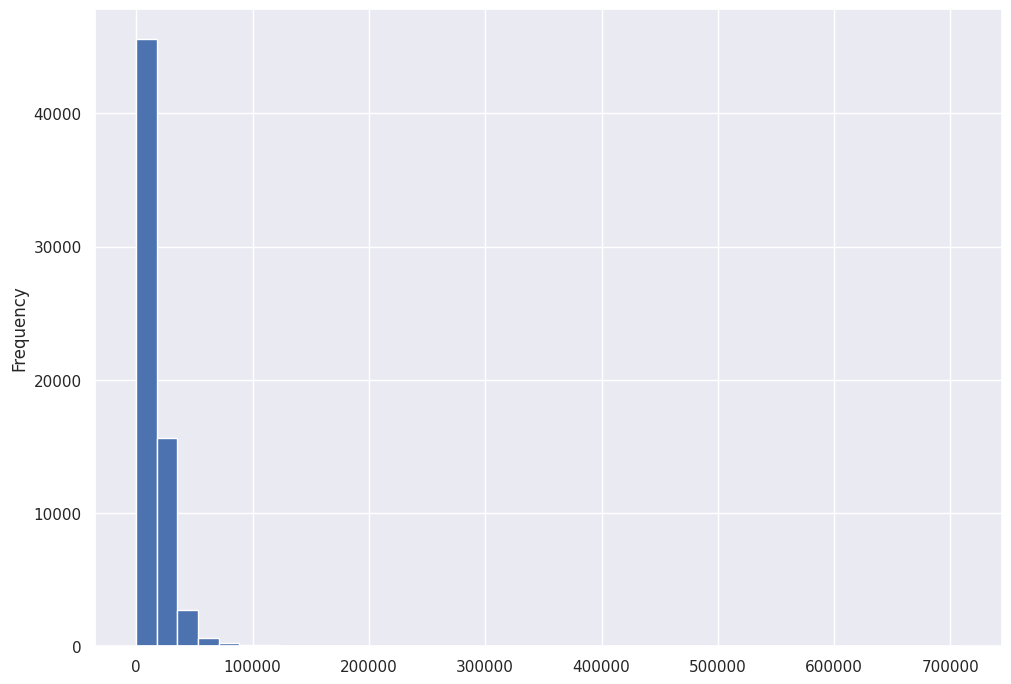

In [53]:
pop_quadras_2022['dens'].plot.hist(bins=40)

# Estimativas para 2010

## Calculando as variáveis correspondentes a cada interseção

In [54]:
est_2010 = sim_10.merge(setores10[['CD_GEOCODI', 'pop_total', 'dom_total']])
est_2010.head()

,CD_GEOCODI,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total
0,355030801000001,38480,"POLYGON ((339655.406 7392796.989, 339657.080 7...",2423.415789,0.041899,806,268
1,355030801000001,38549,"POLYGON ((339528.611 7392680.740, 339459.023 7...",11018.460135,0.190502,806,268
2,355030801000001,39169,"POLYGON ((339714.051 7392604.796, 339672.743 7...",11460.053886,0.198137,806,268
3,355030801000001,39182,"POLYGON ((339547.652 7392665.054, 339547.477 7...",14351.048875,0.248121,806,268
4,355030801000001,55866,"POLYGON ((339779.321 7392944.245, 339779.335 7...",18586.000642,0.321340,806,268


In [55]:
est_2010['pop_total_setor'] = est_2010['pop_total']
est_2010['dom_total_setor'] = est_2010['dom_total']
est_2010['pop_total'] = round(est_2010['pop_total']*est_2010['inter_perc'], 0).astype(int)
est_2010['dom_total'] = round(est_2010['dom_total']*est_2010['inter_perc'], 0).astype(int)
est_2010.head()

,CD_GEOCODI,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total,pop_total_setor,dom_total_setor
0,355030801000001,38480,"POLYGON ((339655.406 7392796.989, 339657.080 7...",2423.415789,0.041899,34,11,806,268
1,355030801000001,38549,"POLYGON ((339528.611 7392680.740, 339459.023 7...",11018.460135,0.190502,154,51,806,268
2,355030801000001,39169,"POLYGON ((339714.051 7392604.796, 339672.743 7...",11460.053886,0.198137,160,53,806,268
3,355030801000001,39182,"POLYGON ((339547.652 7392665.054, 339547.477 7...",14351.048875,0.248121,200,66,806,268
4,355030801000001,55866,"POLYGON ((339779.321 7392944.245, 339779.335 7...",18586.000642,0.321340,259,86,806,268


## Calculando os erros das estimativas

A estimativa por interpolação baseada na área de interseção assume que os domicílios e a população de cada setor são, em média, uniformemente distribuídos entre todas as áreas de interseção entre os setores censitários e quadras.

Felizmente, podemos calcular o erro possível para cada estimativa caso isso não seja verdade, conforme demonstrado em [Schroeder (2007)](https://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.2007.00706.x). Em resumo, não existe erro quando um setor inteiro estiver contido dentro da geometria de uma quadra ou nos setores nos quais a quadra não possui relação.

Porém, quando a quadra intersecta parcialmente um setor, existem duas anomalias possíveis: em um extremo, é possível que toda a população daquele setor esteja concentrada exatamente dentro da área de intereseção com a quadra em questão, então nossa estimativa tem viés de subestimação; no outro, pode ser que não existe população na área de intereseção com a quadra, caso no qual nossa estimativa teria viés de superestimação. Assim, o erro da estimação para cada área de interseção é, no mínimo, $-\hat{y}_{sq}$ e, no máximo, $y_{s}-\hat{y}_{sq}$, sendo $\hat{y}_{sq}$ a estimativa de uma dada interseção entre setor censitário e quadra viária e $y_{q}$ a população total de um dado setor censitário.

Finalmente, o mínimo e máximo de erro para cada quadra será o somatório dos mínimos e máximos de cada interseção daquela quadra.

In [56]:
est_2010['pop_total_min'] = est_2010['pop_total']-est_2010['pop_total']*(est_2010['pop_total']!=est_2010['pop_total_setor'])
est_2010['pop_total_max'] = est_2010['pop_total']+est_2010['pop_total_setor']-est_2010['pop_total']
est_2010['dom_total_min'] = est_2010['dom_total']-est_2010['dom_total']*(est_2010['dom_total']!=est_2010['dom_total_setor'])
est_2010['dom_total_max'] = est_2010['dom_total']+est_2010['dom_total_setor']-est_2010['dom_total']
est_2010.head()

,CD_GEOCODI,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total,pop_total_setor,dom_total_setor,pop_total_min,pop_total_max,dom_total_min,dom_total_max
0,355030801000001,38480,"POLYGON ((339655.406 7392796.989, 339657.080 7...",2423.415789,0.041899,34,11,806,268,0,806,0,268
1,355030801000001,38549,"POLYGON ((339528.611 7392680.740, 339459.023 7...",11018.460135,0.190502,154,51,806,268,0,806,0,268
2,355030801000001,39169,"POLYGON ((339714.051 7392604.796, 339672.743 7...",11460.053886,0.198137,160,53,806,268,0,806,0,268
3,355030801000001,39182,"POLYGON ((339547.652 7392665.054, 339547.477 7...",14351.048875,0.248121,200,66,806,268,0,806,0,268
4,355030801000001,55866,"POLYGON ((339779.321 7392944.245, 339779.335 7...",18586.000642,0.321340,259,86,806,268,0,806,0,268


In [57]:
est_2010[est_2010['pop_total']==est_2010['pop_total_setor']].head()

,CD_GEOCODI,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total,pop_total_setor,dom_total_setor,pop_total_min,pop_total_max,dom_total_min,dom_total_max
35,355030801000009,38585,"POLYGON ((339209.728 7392594.047, 339209.709 7...",51967.142618,1.0,693,245,693,245,693,693,245,245
165,355030801000041,38903,"POLYGON ((340336.541 7392004.552, 340336.350 7...",23059.085816,1.0,923,334,923,334,923,923,334,334
289,355030801000076,47670,"POLYGON ((338459.334 7392706.519, 338459.567 7...",35842.712289,1.0,1107,382,1107,382,1107,1107,382,382
290,355030801000077,47670,"POLYGON ((338457.740 7392676.622, 338457.543 7...",3386.190820,1.0,631,207,631,207,631,631,207,207
313,355030801000085,38716,"POLYGON ((339198.098 7393910.164, 339202.737 7...",9599.702036,1.0,568,199,568,199,568,568,199,199


## Estimando a população por quadra viária

In [58]:
cols = [
    'cd_identificador_quadra_viaria_editada',
    'pop_total',
    'pop_total_min',
    'pop_total_max',
    'dom_total',
    'dom_total_min',
    'dom_total_max',
]
est_2010_agg = est_2010[cols].groupby('cd_identificador_quadra_viaria_editada').sum().reset_index()
est_2010_agg.head()

,cd_identificador_quadra_viaria_editada,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max
0,1,94,0,1439,29,0,446
1,21,47,0,535,15,0,172
2,24,48,0,535,15,0,172
3,26,52,0,535,17,0,172
4,28,61,0,535,20,0,172


In [59]:
pop_quadras_2010 = gdf_quadras.merge(est_2010_agg, how='left')
pop_quadras_2010.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,1439.0,29.0,0.0,446.0
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
pop_quadras_2010.loc[:, cols] = pop_quadras_2010.loc[:, cols].fillna(0)
pop_quadras_2010.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,1439.0,29.0,0.0,446.0
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0


## Calculando a densidade demográfica por quadra viária

In [61]:
pop_quadras_2010['dens'] = pop_quadras_2010['pop_total']/(pop_quadras_2010['qt_area_metro']/1e6)
pop_quadras_2010.loc[pop_quadras_2010['qt_area_metro']==0, 'dens'] = 0
pop_quadras_2010

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max,dens
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,1439.0,29.0,0.0,446.0,12287.581699
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [62]:
pop_quadras_2010['dens'].describe()

count     64784.000000
mean      12992.370436
std       14212.523014
min           0.000000
25%           0.000000
50%       11296.698745
75%       20035.547950
max      526793.557833
Name: dens, dtype: float64

<Axes: ylabel='Frequency'>

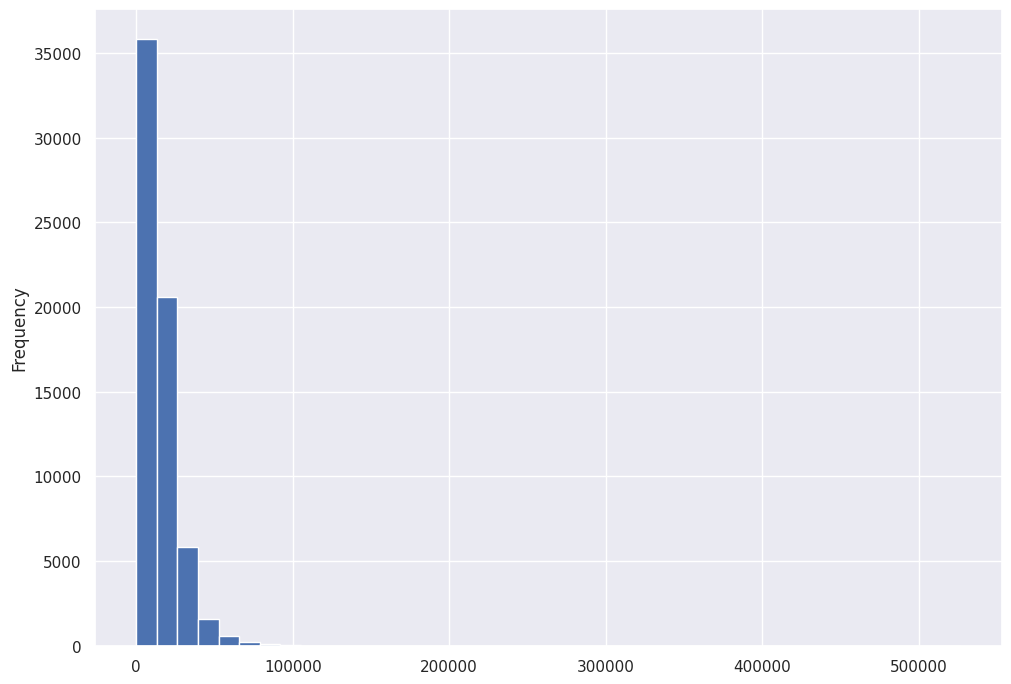

In [63]:
pop_quadras_2010['dens'].plot.hist(bins=40)

# Estimativas para 2000

## Calculando as variáveis correspondentes a cada interseção

In [64]:
est_2000 = sim_00.merge(setores00[['ID_', 'pop_total', 'dom_total']])
est_2000.head()

,ID_,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total
0,355030801000001,38480,"POLYGON ((339634.718 7392762.465, 339634.874 7...",2071.446783,0.036049,806,269
1,355030801000001,38549,"POLYGON ((339475.817 7392747.163, 339534.864 7...",8621.638093,0.150042,806,269
2,355030801000001,38672,"POLYGON ((339551.208 7392832.220, 339622.771 7...",1451.521608,0.025261,806,269
3,355030801000001,38891,"POLYGON ((339829.137 7392989.685, 339831.020 7...",511.898263,0.008909,806,269
4,355030801000001,39169,"POLYGON ((339784.195 7392602.000, 339728.941 7...",9785.463664,0.170296,806,269


In [65]:
est_2000['pop_total_setor'] = est_2000['pop_total']
est_2000['dom_total_setor'] = est_2000['dom_total']
est_2000['pop_total'] = round(est_2000['pop_total']*est_2000['inter_perc'], 0).astype(int)
est_2000['dom_total'] = round(est_2000['dom_total']*est_2000['inter_perc'], 0).astype(int)
est_2000.head()

,ID_,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total,pop_total_setor,dom_total_setor
0,355030801000001,38480,"POLYGON ((339634.718 7392762.465, 339634.874 7...",2071.446783,0.036049,29,10,806,269
1,355030801000001,38549,"POLYGON ((339475.817 7392747.163, 339534.864 7...",8621.638093,0.150042,121,40,806,269
2,355030801000001,38672,"POLYGON ((339551.208 7392832.220, 339622.771 7...",1451.521608,0.025261,20,7,806,269
3,355030801000001,38891,"POLYGON ((339829.137 7392989.685, 339831.020 7...",511.898263,0.008909,7,2,806,269
4,355030801000001,39169,"POLYGON ((339784.195 7392602.000, 339728.941 7...",9785.463664,0.170296,137,46,806,269


## Calculando os erros das estimativas

A estimativa por interpolação baseada na área de interseção assume que os domicílios e a população de cada setor são, em média, uniformemente distribuídos entre todas as áreas de interseção entre os setores censitários e quadras.

Felizmente, podemos calcular o erro possível para cada estimativa caso isso não seja verdade, conforme demonstrado em [Schroeder (2007)](https://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.2007.00706.x). Em resumo, não existe erro quando um setor inteiro estiver contido dentro da geometria de uma quadra ou nos setores nos quais a quadra não possui relação.

Porém, quando a quadra intersecta parcialmente um setor, existem duas anomalias possíveis: em um extremo, é possível que toda a população daquele setor esteja concentrada exatamente dentro da área de intereseção com a quadra em questão, então nossa estimativa tem viés de subestimação; no outro, pode ser que não existe população na área de intereseção com a quadra, caso no qual nossa estimativa teria viés de superestimação. Assim, o erro da estimação para cada área de interseção é, no mínimo, $-\hat{y}_{sq}$ e, no máximo, $y_{s}-\hat{y}_{sq}$, sendo $\hat{y}_{sq}$ a estimativa de uma dada interseção entre setor censitário e quadra viária e $y_{q}$ a população total de um dado setor censitário.

Finalmente, o mínimo e máximo de erro para cada quadra será o somatório dos mínimos e máximos de cada interseção daquela quadra.

In [66]:
est_2000['pop_total_min'] = est_2000['pop_total']-est_2000['pop_total']*(est_2000['pop_total']!=est_2000['pop_total_setor'])
est_2000['pop_total_max'] = est_2000['pop_total']+est_2000['pop_total_setor']-est_2000['pop_total']
est_2000['dom_total_min'] = est_2000['dom_total']-est_2000['dom_total']*(est_2000['dom_total']!=est_2000['dom_total_setor'])
est_2000['dom_total_max'] = est_2000['dom_total']+est_2000['dom_total_setor']-est_2000['dom_total']
est_2000.head()

,ID_,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total,pop_total_setor,dom_total_setor,pop_total_min,pop_total_max,dom_total_min,dom_total_max
0,355030801000001,38480,"POLYGON ((339634.718 7392762.465, 339634.874 7...",2071.446783,0.036049,29,10,806,269,0,806,0,269
1,355030801000001,38549,"POLYGON ((339475.817 7392747.163, 339534.864 7...",8621.638093,0.150042,121,40,806,269,0,806,0,269
2,355030801000001,38672,"POLYGON ((339551.208 7392832.220, 339622.771 7...",1451.521608,0.025261,20,7,806,269,0,806,0,269
3,355030801000001,38891,"POLYGON ((339829.137 7392989.685, 339831.020 7...",511.898263,0.008909,7,2,806,269,0,806,0,269
4,355030801000001,39169,"POLYGON ((339784.195 7392602.000, 339728.941 7...",9785.463664,0.170296,137,46,806,269,0,806,0,269


In [67]:
est_2000[est_2000['pop_total']==est_2000['pop_total_setor']].head()

,ID_,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,pop_total,dom_total,pop_total_setor,dom_total_setor,pop_total_min,pop_total_max,dom_total_min,dom_total_max
1089,355030802000019,42873,"POLYGON ((324772.000 7395178.000, 324817.000 7...",1890.0,1.0,729,268,729,268,729,729,268,268
1090,355030802000020,42873,"POLYGON ((324832.000 7395247.000, 324874.000 7...",1806.0,1.0,610,222,610,222,610,610,222,222
1091,355030802000021,42873,"POLYGON ((324771.000 7395303.000, 324809.000 7...",1482.0,1.0,543,216,543,216,543,543,216,216
1092,355030802000022,50921,"POLYGON ((324618.000 7395474.000, 324669.000 7...",2703.0,1.0,685,217,685,217,685,685,217,217
1093,355030802000023,50921,"POLYGON ((324509.000 7395701.000, 324554.000 7...",1620.0,1.0,661,208,661,208,661,661,208,208


## Estimando a população por quadra viária

In [68]:
cols = [
    'cd_identificador_quadra_viaria_editada',
    'pop_total',
    'pop_total_min',
    'pop_total_max',
    'dom_total',
    'dom_total_min',
    'dom_total_max',
]
est_2000_agg = est_2000[cols].groupby('cd_identificador_quadra_viaria_editada').sum().reset_index()
est_2000_agg.head()

,cd_identificador_quadra_viaria_editada,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max
0,1,63,0,1831,17,0,501
1,21,36,0,1049,10,0,287
2,24,35,0,1049,10,0,287
3,26,39,0,2282,11,0,661
4,28,47,0,2282,13,0,661


In [69]:
pop_quadras_2000 = gdf_quadras.merge(est_2000_agg, how='left')
pop_quadras_2000.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,63.0,0.0,1831.0,17.0,0.0,501.0
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
pop_quadras_2000.loc[:, cols] = pop_quadras_2000.loc[:, cols].fillna(0)
pop_quadras_2000.head()

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,63.0,0.0,1831.0,17.0,0.0,501.0
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0


## Calculando a densidade demográfica por quadra viária

In [71]:
pop_quadras_2000['dens'] = pop_quadras_2000['pop_total']/(pop_quadras_2000['qt_area_metro']/1e6)
pop_quadras_2000.loc[pop_quadras_2000['qt_area_metro']==0, 'dens'] = 0
pop_quadras_2000

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max,dens
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,63.0,0.0,1831.0,17.0,0.0,501.0,8235.294118
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [72]:
pop_quadras_2000['dens'].describe()

count     64784.000000
mean      12169.874589
std       12716.610512
min           0.000000
25%           0.000000
50%       10884.292549
75%       19301.950422
max      394436.310395
Name: dens, dtype: float64

<Axes: ylabel='Frequency'>

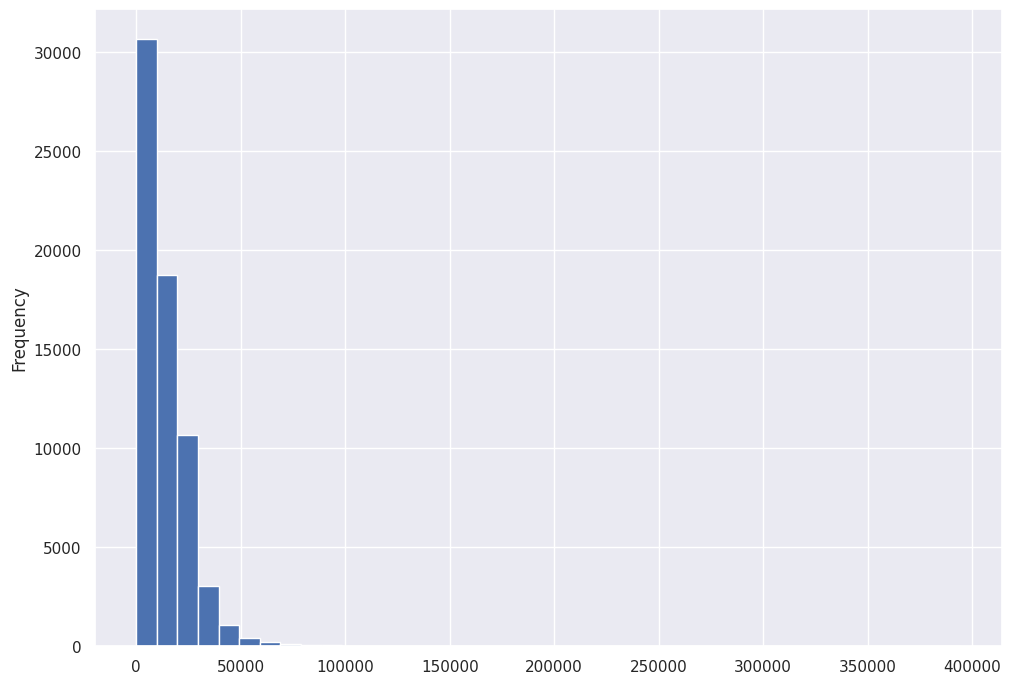

In [73]:
pop_quadras_2000['dens'].plot.hist(bins=40)

# Variação na densidade demográfica

Vamos concatenar os dataframes de estimativa de cada ano. Para isso, precisamos primeiro adicionar uma coluna com o ano do censo.

In [74]:
pop_quadras_2022['censo'] = 2022
pop_quadras_2010['censo'] = 2010
pop_quadras_2000['censo'] = 2000

Por segurança, vamos revisar as colunas e garantir compatibilidade.

In [75]:
pop_quadras_2022.dtypes

geometry                                           geometry
cd_identificador_quadra_viaria_editada                int64
cd_identificador_quadra_viaria_editada_original       int64
tx_tipo_quadra_viaria                                object
tx_escala                                            object
tx_ano_referencia                                    object
qt_area_metro                                         int64
sg_fonte_original                                    object
pop_total                                           float64
pop_total_min                                       float64
pop_total_max                                       float64
dom_total                                           float64
dom_total_min                                       float64
dom_total_max                                       float64
dens                                                float64
censo                                                 int64
dtype: object

In [76]:
pop_quadras_2010.dtypes

geometry                                           geometry
cd_identificador_quadra_viaria_editada                int64
cd_identificador_quadra_viaria_editada_original       int64
tx_tipo_quadra_viaria                                object
tx_escala                                            object
tx_ano_referencia                                    object
qt_area_metro                                         int64
sg_fonte_original                                    object
pop_total                                           float64
pop_total_min                                       float64
pop_total_max                                       float64
dom_total                                           float64
dom_total_min                                       float64
dom_total_max                                       float64
dens                                                float64
censo                                                 int64
dtype: object

In [77]:
pop_quadras_2010.dtypes

geometry                                           geometry
cd_identificador_quadra_viaria_editada                int64
cd_identificador_quadra_viaria_editada_original       int64
tx_tipo_quadra_viaria                                object
tx_escala                                            object
tx_ano_referencia                                    object
qt_area_metro                                         int64
sg_fonte_original                                    object
pop_total                                           float64
pop_total_min                                       float64
pop_total_max                                       float64
dom_total                                           float64
dom_total_min                                       float64
dom_total_max                                       float64
dens                                                float64
censo                                                 int64
dtype: object

In [78]:
quadras_final = pd.concat([
    pop_quadras_2000,
    pop_quadras_2010,
    pop_quadras_2022
])
quadras_final

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max,dens,censo
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,63.0,0.0,1831.0,17.0,0.0,501.0,8235.294118,2000
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2000
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2000
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2000
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64779,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2022
64780,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2022
64781,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2022
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2022


O dataframe final deve manter a mesma quantidade de linhas que os 3 dataframs separadamente, mas vamos checar o tamanho dos dataframes antes e depois.

In [79]:
pop_quadras_2022.shape

(64784, 16)

In [80]:
pop_quadras_2010.shape

(64784, 16)

In [81]:
pop_quadras_2000.shape

(64784, 16)

In [82]:
quadras_final.shape

(194352, 16)

In [83]:
quadras_final.shape[0]//3

64784

In [84]:
(
    quadras_final
    .sort_values(['cd_identificador_quadra_viaria_editada', 'censo'])
)

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max,dens,censo
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,63.0,0.0,1831.0,17.0,0.0,501.0,8235.294118,2000
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,94.0,0.0,1439.0,29.0,0.0,446.0,12287.581699,2010
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,154.0,0.0,869.0,55.0,0.0,308.0,20130.718954,2022
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2000
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2010
64782,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2022
64783,"POLYGON ((354924.398 7388936.251, 354925.815 7...",64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,1002.0,0.0,3861.0,256.0,0.0,985.0,926.798632,2000
64783,"POLYGON ((354924.398 7388936.251, 354925.815 7...",64784,96121,Quadra,1:6.000,2019,1081141,SMUL/GEOINFO,5828.0,4619.0,7964.0,1646.0,1319.0,2254.0,5390.601226,2010


Finalmente, calculo as diferenças entre os anos para cada quadra viária

In [85]:
quadras_var = (
    quadras_final
    .sort_values(['cd_identificador_quadra_viaria_editada', 'censo'])
    .set_index(['cd_identificador_quadra_viaria_editada', 'censo'])
    [['pop_total', 'dom_total', 'dens']]
    .diff()
    .reset_index()
)
quadras_var

,cd_identificador_quadra_viaria_editada,censo,pop_total,dom_total,dens
0,1,2000,NaN,NaN,NaN
1,1,2010,31.0,12.0,4052.287582
2,1,2022,60.0,26.0,7843.137255
3,2,2000,-154.0,-55.0,-20130.718954
4,2,2010,0.0,0.0,0.000000
...,...,...,...,...,...
194347,64783,2010,0.0,0.0,0.000000
194348,64783,2022,0.0,0.0,0.000000
194349,64784,2000,1002.0,256.0,926.798632
194350,64784,2010,4826.0,1390.0,4463.802594


In [86]:
quadras_var.loc[quadras_var['censo']==2000, ['pop_total', 'dom_total', 'dens']] = np.nan
quadras_var = quadras_var.rename(columns={'pop_total':'var_pop', 'dom_total':'var_dom', 'dens': 'var_dens'})
quadras_var

,cd_identificador_quadra_viaria_editada,censo,var_pop,var_dom,var_dens
0,1,2000,NaN,NaN,NaN
1,1,2010,31.0,12.0,4052.287582
2,1,2022,60.0,26.0,7843.137255
3,2,2000,NaN,NaN,NaN
4,2,2010,0.0,0.0,0.000000
...,...,...,...,...,...
194347,64783,2010,0.0,0.0,0.000000
194348,64783,2022,0.0,0.0,0.000000
194349,64784,2000,NaN,NaN,NaN
194350,64784,2010,4826.0,1390.0,4463.802594


E trago as variações para o geodataframe final.

In [87]:
quadras_final = quadras_final.merge(quadras_var, on=['cd_identificador_quadra_viaria_editada', 'censo'])
quadras_final

,geometry,cd_identificador_quadra_viaria_editada,cd_identificador_quadra_viaria_editada_original,tx_tipo_quadra_viaria,tx_escala,tx_ano_referencia,qt_area_metro,sg_fonte_original,pop_total,pop_total_min,pop_total_max,dom_total,dom_total_min,dom_total_max,dens,censo,var_pop,var_dom,var_dens
0,"POLYGON ((338344.482 7407584.661, 338344.543 7...",1,52943,Quadra,1:1.000,2004,7650,SMUL/GEOINFO,63.0,0.0,1831.0,17.0,0.0,501.0,8235.294118,2000,NaN,NaN,NaN
1,"POLYGON ((327186.316 7377154.793, 327188.886 7...",2,4,Praca_Canteiro,1:1.000,2004,11,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2000,NaN,NaN,NaN
2,"POLYGON ((324545.386 7402131.104, 324544.170 7...",3,5,Praca_Canteiro,1:1.000,2004,6,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2000,NaN,NaN,NaN
3,"POLYGON ((326273.589 7399282.971, 326273.013 7...",4,6,Praca_Canteiro,1:1.000,2004,109,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2000,NaN,NaN,NaN
4,"POLYGON ((322149.447 7392535.031, 322154.771 7...",5,7,Praca_Canteiro,1:1.000,2004,12,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194347,"POLYGON ((325071.550 7397335.276, 325073.371 7...",64780,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2022,0.0,0.0,0.000000
194348,"POLYGON ((325064.631 7397341.102, 325065.814 7...",64781,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2022,0.0,0.0,0.000000
194349,"POLYGON ((325102.327 7397333.002, 325089.121 7...",64782,58914,Praca_Canteiro,1:1.000,2004,25982,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2022,0.0,0.0,0.000000
194350,"POLYGON ((325081.631 7397226.147, 325087.148 7...",64783,0,Praca_Canteiro,1:1.000,2017,0,SMUL/GEOINFO,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2022,0.0,0.0,0.000000


In [88]:
quadras_estimativa_path = 'data/11_estimativa_quadras.parquet'
quadras_final.to_parquet(quadras_estimativa_path)

# Adicionando renda como um nível hierárquico

Para avaliar a hipótese de que os EETU tem impacto em zonar que já possuem interesse imobiliário, vamos utilizar a renda das quadras em 2010 como proxy da demanda por moradia naquela quadra.

Primeiro, tratamos os valores omitidos.

<Axes: >

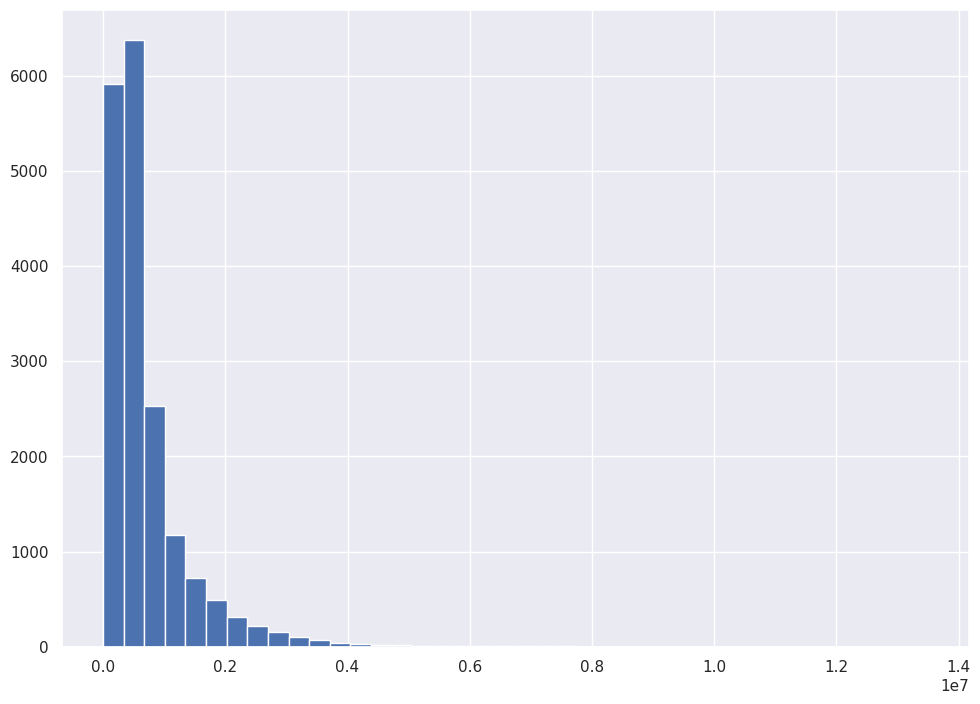

In [55]:
dados10_renda.loc[dados10_renda['V002']=='X', 'V002'] = np.nan
dados10_renda.loc[~dados10_renda['V002'].isna(), 'V002'] = dados10_renda.loc[~dados10_renda['V002'].isna(), 'V002'].astype(int)
dados10_renda['V002'].hist(bins=40)

In [64]:
dados10_renda['V002'].astype(float).describe()

count    1.820600e+04
mean     6.937342e+05
std      7.190271e+05
min      0.000000e+00
25%      2.837632e+05
50%      4.739875e+05
75%      8.190162e+05
max      1.348729e+07
Name: V002, dtype: float64

Agora, estimamos os o rendimento total para cada quadra.

In [56]:
setores10 = setores10.merge(dados10_renda[['Cod_setor', 'V002']], left_on='CD_GEOCODI', right_on='Cod_setor')
setores10 = setores10.drop(columns='Cod_setor')
setores10 = setores10.rename(columns={'V002': 'rend_total'})
setores10.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry,pop_total,dom_total,rend_total
0,109347.0,355030804000079,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42323,"POLYGON ((345114.562 7391509.505, 345106.759 7...",554,179,432103
1,109348.0,355030804000080,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42324,"POLYGON ((345002.927 7391486.947, 344983.085 7...",713,238,449239
2,109349.0,355030804000081,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42325,"POLYGON ((344874.928 7391332.868, 344864.237 7...",685,203,411373
3,109350.0,355030804000082,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42326,"POLYGON ((344746.124 7391456.534, 344742.477 7...",902,279,629889
4,109351.0,355030804000083,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42327,"POLYGON ((344512.429 7391240.196, 344500.243 7...",602,186,320125


In [71]:
est_renda = (
    sim_10.merge(setores10[['CD_GEOCODI', 'rend_total', 'dom_total']])
)
est_renda.head()

,CD_GEOCODI,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,rend_total,dom_total
0,355030801000001,38480,"POLYGON ((339655.406 7392796.989, 339657.080 7...",2423.415789,0.041899,907777,268
1,355030801000001,38549,"POLYGON ((339528.611 7392680.740, 339459.023 7...",11018.460135,0.190502,907777,268
2,355030801000001,39169,"POLYGON ((339714.051 7392604.796, 339672.743 7...",11460.053886,0.198137,907777,268
3,355030801000001,39182,"POLYGON ((339547.652 7392665.054, 339547.477 7...",14351.048875,0.248121,907777,268
4,355030801000001,55866,"POLYGON ((339779.321 7392944.245, 339779.335 7...",18586.000642,0.321340,907777,268


In [72]:
setores10[setores10['rend_total'].isna()]

,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry,pop_total,dom_total,rend_total
284,109181.0,355030803000034,RURAL,35503080300,None,355030803,ANHANGUERA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,43643,"POLYGON ((318192.660 7407459.219, 318192.000 7...",12,3,NaN
293,109190.0,355030803000043,RURAL,35503080300,None,355030803,ANHANGUERA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,43652,"POLYGON ((318490.340 7407205.047, 318490.390 7...",15,4,NaN
294,109191.0,355030803000044,RURAL,35503080300,None,355030803,ANHANGUERA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,43653,"POLYGON ((316334.965 7407669.522, 316373.606 7...",5,2,NaN
315,109218.0,355030803000071,URBANO,35503080300,None,355030803,ANHANGUERA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,43680,"POLYGON ((318508.682 7410003.381, 318532.315 7...",5,1,NaN
326,109232.0,355030803000085,URBANO,35503080300,None,355030803,ANHANGUERA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,43694,"POLYGON ((316758.764 7405359.468, 316718.307 7...",18,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17541,127054.0,355030892000188,URBANO,35503089200,None,355030892,VILA MEDEIROS,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,61473,"POLYGON ((339717.068 7401138.517, 339724.721 7...",16,4,NaN
17910,127402.0,355030894000153,URBANO,35503089400,None,355030894,VILA SÔNIA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,61925,"POLYGON ((321060.690 7390448.130, 321131.585 7...",26,10,NaN
18006,127517.0,355030894000268,URBANO,35503089400,None,355030894,VILA SÔNIA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62026,"POLYGON ((322405.682 7388998.312, 322383.058 7...",13,3,NaN
18094,127606.0,355030895000087,URBANO,35503089500,None,355030895,SÃO DOMINGOS,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62115,"POLYGON ((321028.049 7402764.606, 321030.738 7...",9,2,NaN


In [74]:
est_renda['rend_total_setor'] = est_renda['rend_total']
est_renda['dom_total_setor'] = est_renda['dom_total']
est_renda['rend_total'] = round(est_renda['rend_total']*est_renda['inter_perc'], 2)
est_renda['dom_total'] = round(est_renda['dom_total']*est_renda['inter_perc'], 0).astype(int)
est_renda.head()

,CD_GEOCODI,cd_identificador_quadra_viaria_editada,geometry,inter_area,inter_perc,rend_total,dom_total,rend_total_setor,dom_total_setor
0,355030801000001,38480,"POLYGON ((339655.406 7392796.989, 339657.080 7...",2423.415789,0.041899,1593.653131,0,38035.268609,11
1,355030801000001,38549,"POLYGON ((339528.611 7392680.740, 339459.023 7...",11018.460135,0.190502,32944.258996,10,172933.630617,51
2,355030801000001,39169,"POLYGON ((339714.051 7392604.796, 339672.743 7...",11460.053886,0.198137,35637.830141,11,179864.400401,53
3,355030801000001,39182,"POLYGON ((339547.652 7392665.054, 339547.477 7...",14351.048875,0.248121,55886.282416,16,225238.277814,66
4,355030801000001,55866,"POLYGON ((339779.321 7392944.245, 339779.335 7...",18586.000642,0.321340,93736.736611,28,291705.422559,86


In [82]:
est_renda_agg = (
    est_renda
    [['cd_identificador_quadra_viaria_editada', 'rend_total', 'dom_total']]
    .groupby('cd_identificador_quadra_viaria_editada')
    .agg('sum')
    .reset_index()
)
est_renda_agg

,cd_identificador_quadra_viaria_editada,rend_total,dom_total
0,1,3733.997252,2
1,21,10024.020659,1
2,24,10418.267493,1
3,26,12260.39975,2
4,28,17180.635783,2
...,...,...,...
46383,64768,5184393.551597,2064
46384,64771,236964.606125,211
46385,64772,8822.812223,8
46386,64773,182592.243271,133


In [84]:
dom_filter = est_renda_agg['dom_total']>0
est_renda_agg.loc[dom_filter, 'rend_med_dom'] = est_renda_agg.loc[dom_filter, 'rend_total']/est_renda_agg.loc[dom_filter, 'dom_total']
est_renda_agg

,cd_identificador_quadra_viaria_editada,rend_total,dom_total,rend_med_dom
0,1,3733.997252,2,1866.998626
1,21,10024.020659,1,10024.020659
2,24,10418.267493,1,10418.267493
3,26,12260.39975,2,6130.199875
4,28,17180.635783,2,8590.317891
...,...,...,...,...
46383,64768,5184393.551597,2064,2511.818581
46384,64771,236964.606125,211,1123.055005
46385,64772,8822.812223,8,1102.851528
46386,64773,182592.243271,133,1372.87401


<Axes: >

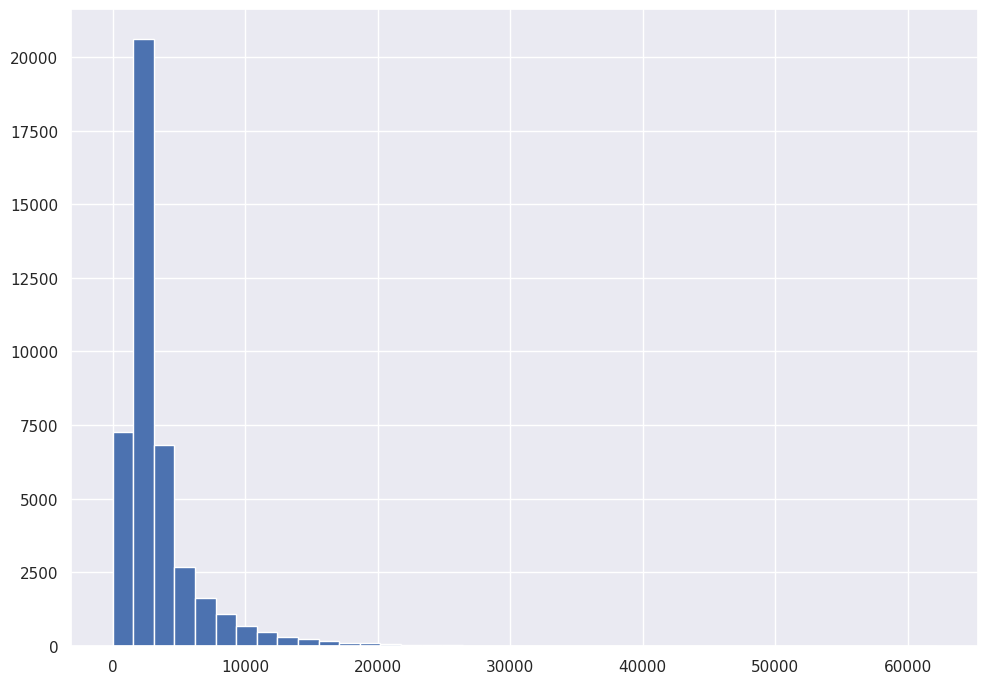

In [85]:
est_renda_agg['rend_med_dom'].hist(bins=40)

In [92]:
est_renda_agg['rend_med_dom'].astype(float).describe(percentiles=[i/10 for i in range(2, 10)])

count    42348.000000
mean      3478.945737
std       3284.468559
min          0.000000
20%       1622.568452
30%       1871.467444
40%       2133.138942
50%       2435.531074
60%       2807.155848
70%       3372.552196
80%       4349.279699
90%       6837.964798
max      62185.765867
Name: rend_med_dom, dtype: float64

In [89]:
#TODO atualizar as visualizações

# Visualizando a estimativa de população e densidade demográfica

In [63]:
def create_map(df:gpd.GeoDataFrame, col_mapper:dict, legend_column:str, base:str='2022', **kwargs) -> folium.Map:
    
    df = df[[k for k in col_mapper]].copy()
    # df = df[df['pop_total'].astype(int) > 0]
    df = df.rename(columns=col_mapper)
    if base == '2022':
        # m = setores10[['CD_GEOCODI', 'pop_total', 'geometry']].explore(
        #     tiles="CartoDB positron",  # use "CartoDB positron" tiles
        #     name='Setores censitários (2010)',
        #     color='grey',
        #     style_kwds={'fillOpacity': 0.1},
        # )
        
        # m = est_2010[['CD_SETOR', 'CD_GEOCODI', 'pop_total', 'geometry']].explore(
        #     m=m,
        #     name='Similaridades',
        #     color='grey',
        #     style_kwds={'fillOpacity': 0.1},
        #     show=False,
        # )
        
        m = setores22[['CD_SETOR', 'pop_total', 'geometry']].explore(
            tiles="CartoDB positron",  # use "CartoDB positron" tiles
            name='Setores censitários (2022)',
            color='grey',
            style_kwds={'fillOpacity': 0.1},
        )
    
        m = setores22[['geometry']].dissolve().explore(
            m=m,
            name='Limite municipal',
            color='black',
            style_kwds={'fill': False},
        )
    elif base == '2010':
        m = setores22[['CD_SETOR', 'pop_total', 'geometry']].explore(
            tiles="CartoDB positron",  # use "CartoDB positron" tiles
            name='Setores censitários (2022)',
            color='grey',
            style_kwds={'fillOpacity': 0.1},
        )
        
        m = est_2022[['CD_GEOCODI', 'CD_SETOR', 'pop_total', 'geometry']].explore(
            m=m,
            name='Similaridades',
            color='grey',
            style_kwds={'fillOpacity': 0.1},
            show=False,
        )
    
        m = setores10[['geometry']].dissolve().explore(
            m=m,
            name='Limite municipal',
            color='black',
            style_kwds={'fill': False},
        )

    defaultKwargs = {
        # 'scheme': 'quantiles',
        'cmap': 'coolwarm',
        # 'k': 10,
        'legend_kwds': {'colorbar': True}
    }
    kwargs = { **defaultKwargs, **kwargs }

    popup_cols = [
        # 'Setor censitário',
        # 'Distrito',
        'População total (2010)',
        'População total (2022)',
        # 'Variação populacional (absoluta)',
        # 'Variação populacional (%)',
        'Densidade demográfica - 2022 (hab/km^2)',
        'Densidade demográfica - 2010 (hab/km^2)',
        'Variação na densidade demográfica (hab/km^2)',
        # 'Variação na densidade demográfica normalizada (raiz cúbica)',
    ]
        
    m = df.explore(
        m=m,
        column=legend_column,  # make choropleth based on "POP2010" column
        legend=True,  # show legend
        tooltip=popup_cols,
        popup=popup_cols,
        # legend_kwds=dict(colorbar=True, scale=False),  # do not use colorbar
        # legend_kwds=dict(colorbar=True),  # do not use colorbar
        name=legend_column,  # name of the layer in the map,
        **kwargs
    )
    
    folium.LayerControl().add_to(m)

    folium_plugins.Fullscreen(
        position='topright',
        title='Tela cheia',
        title_cancel='Exit me',
        force_separate_button=True,
    ).add_to(m)

    return m

In [64]:
mapper_final = {
    'cd_identificador_quadra_viaria_editada': 'Quadra viária',
    'pop_total': 'População total (2022)',
    'pop_total_prev': 'População total (2010)',
    # 'var_pop': 'Variação populacional (absoluta)',
    # 'var_pop_perc': 'Variação populacional (percentual)',
    # 'var_pop_perc_str': 'Variação populacional (%)',
    'var_dens': 'Variação na densidade demográfica (hab/km^2)',
    # 'cbrt_var_dens': 'Variação na densidade demográfica normalizada (raiz cúbica)',
    'dens_22': 'Densidade demográfica - 2022 (hab/km^2)',
    'dens_10': 'Densidade demográfica - 2010 (hab/km^2)',
    'geometry': 'geometry'
}

In [65]:
%%time
m = create_map(quadras_final, mapper_final, 'Densidade demográfica - 2022 (hab/km^2)', cmap='Reds')

CPU times: user 20.3 s, sys: 677 ms, total: 21 s
Wall time: 21.2 s


In [66]:
%%time
m.save('plots/Densidade demográfica - Quadras viárias.html')

CPU times: user 33.1 s, sys: 2.7 s, total: 35.8 s
Wall time: 50.7 s


In [67]:
%%time
m = create_map(
    quadras_final,
    mapper_final,
    'Densidade demográfica - 2022 (hab/km^2)',
    scheme='quantiles',
    k=10,
    legend_kwds={'colorbar': False},
    cmap='Reds',
)

/home/d855395/git/compatibilizacao-setores-censitarios/env/lib/python3.12/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 10 classes. Setting k to 9.
  self.bins = quantile(y, k=k)


CPU times: user 21 s, sys: 605 ms, total: 21.6 s
Wall time: 31.3 s


In [68]:
%%time
m.save('plots/Densidade demográfica - Quadras viárias - categorias.html')

CPU times: user 34.6 s, sys: 3.22 s, total: 37.8 s
Wall time: 54.4 s


In [69]:
%%time
m = create_map(
    quadras_final,
    mapper_final,
    'Variação na densidade demográfica (hab/km^2)',
    scheme='quantiles',
    k=10,
    legend_kwds={'colorbar': False},
)

/home/d855395/git/compatibilizacao-setores-censitarios/env/lib/python3.12/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 10 classes. Setting k to 8.
  self.bins = quantile(y, k=k)


CPU times: user 22.2 s, sys: 568 ms, total: 22.7 s
Wall time: 28.2 s


In [70]:
%%time
m.save('plots/Variação na densidade demográfica - Quadras viárias.html')

CPU times: user 33 s, sys: 1.78 s, total: 34.8 s
Wall time: 36.8 s
